In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import configs
import os
from auxrl.Agent import Agent
from auxrl.networks.Network import Network
import yaml

from acme import specs, wrappers

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Foraging

In [3]:
from auxrl.environments.GridWorld import Env as Env 

In [4]:
dim = 16
nn_yaml = 'dm'
base_exp = 'test2'
exp = f'{base_exp}_{nn_yaml}_dim{dim}'
fname = f'{base_exp}_mf'
_iter = 0

In [5]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [6]:
fname_nnet_dir = f'/mnt/smb/locker/aronov-locker/Ching/rl/nnets/{exp}/{fname}_{_iter}/'

In [7]:
with open(f'{engram_dir}params/{exp}/{fname}.yaml', 'r') as f:
    parameters = yaml.safe_load(f)

In [8]:
parameters['fname'] = f'{exp}/{fname}_{_iter}'
parameters['internal_dim'] = dim
parameters['nn_yaml'] = nn_yaml

In [9]:
env = Env(**parameters['dset_args'])

goal set
[[-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]]


In [10]:
env_spec = specs.make_environment_spec(env)
network = Network(env_spec, device=device, **parameters['network_args'])
agent = Agent(env_spec, network, device=device, **parameters['agent_args'])

In [11]:
with open(f'{fname_nnet_dir}goal.txt', 'r') as f:
    goal_state = f.read()
    print(goal_state)
goal_state = (int(goal_state[1]), int(goal_state[-2]))

(1, 6)


In [12]:
env.goal_state = goal_state

goal set
[[-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1.  0.  0.  0.  0.  0.  1. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1.  0.  0.  0.  0.  0.  0. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]]


In [14]:
agent.load_network(fname_nnet_dir, episode=200, encoder_only=False)

In [15]:
from auxrl.utils import run_eval_episode

In [16]:
import warnings
warnings.filterwarnings("ignore")

tensor([0.1288, 0.1226, 0.1052, 0.1317], device='cuda:0')
tensor([0.2355, 0.1743, 0.1615, 0.2222], device='cuda:0')
tensor([0.3810, 0.2434, 0.2343, 0.3472], device='cuda:0')
tensor([0.4946, 0.3093, 0.3027, 0.4658], device='cuda:0')
tensor([0.5612, 0.3897, 0.3696, 0.6177], device='cuda:0')
tensor([0.7057, 0.4675, 0.4534, 0.7526], device='cuda:0')
tensor([0.8679, 0.5341, 0.5395, 0.8417], device='cuda:0')
tensor([0.9142, 0.6277, 0.6012, 1.0412], device='cuda:0')
[EVAL] 1.0 score over 8.0 steps.


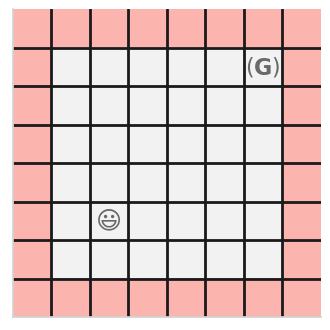

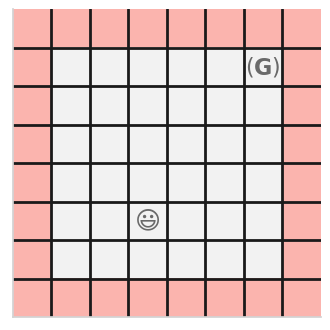

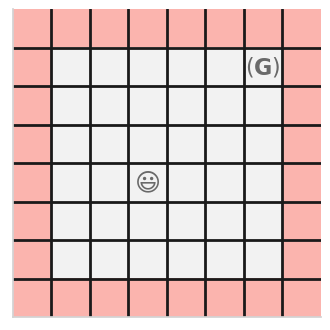

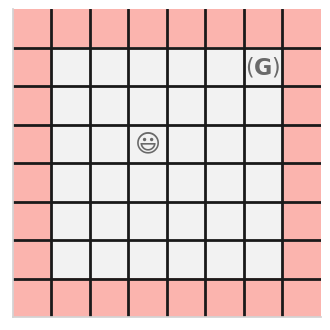

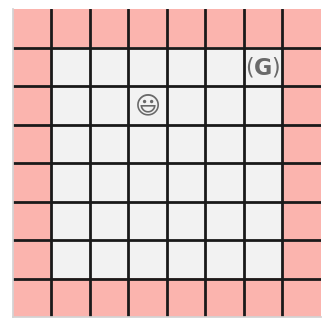

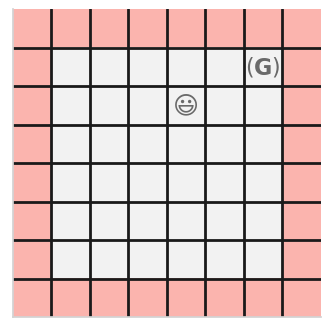

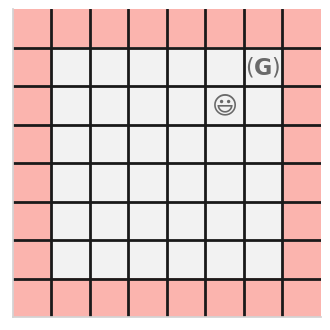

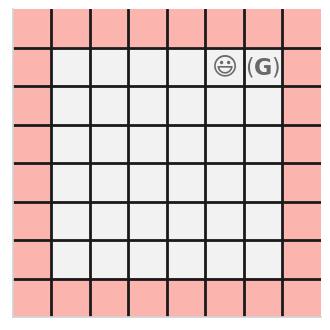

In [50]:
%matplotlib inline
env._start_state = env._sample_start()
score, steps_per_episode = run_eval_episode(env, agent, 1, verbose=True)

# Alternating T Maze

In [2]:
from deer.environments.Figure8 import MyEnv as Env 

In [22]:
fname = 'altT_mb'

In [23]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

In [24]:
with open(f'{engram_dir}params/{fname}.yaml', 'r') as f:
    parameters = yaml.safe_load(f)

In [53]:
parameters['fname'] = 'altT_dm_dim10/altT_mb_4'
parameters['internal_dim'] = 10

In [54]:
policy_eps=0.5

In [55]:
env = Env(                                                                     
    give_rewards=parameters['figure8_give_rewards'],                           
    higher_dim_obs=parameters['higher_dim_obs'],                               
    show_rewards=parameters['show_rewards'], plotfig=False                     
    ) 

In [56]:
rng = np.random.RandomState()
learning_algo = CRAR(                                                          
    env, parameters['freeze_interval'], parameters['batch_size'], rng,         
    internal_dim=parameters['internal_dim'], lr=parameters['learning_rate'],
    nn_yaml=parameters['nn_yaml'], yaml_mods=parameters['yaml_mods'],          
    double_Q=True, loss_weights=parameters['loss_weights'],                    
    encoder_type=parameters['encoder_type'], mem_len=parameters['mem_len'],
    train_len=parameters['train_len']  
    )   

In [57]:
train_policy = EpsilonGreedyPolicy(                                     
    learning_algo, env.nActions(), rng, epsilon=policy_eps)             
test_policy = EpsilonGreedyPolicy(                                      
    learning_algo, env.nActions(), rng, 0.)  

In [58]:
agent = NeuralAgent(                                                        
    env, learning_algo, parameters['replay_memory_size'], 1,                
    parameters['batch_size'], rng, save_dir=engram_dir,                     
    train_policy=train_policy, test_policy=test_policy)
agent.attach(bc.LearningRateController(                                     
    initial_learning_rate=parameters['learning_rate'],                      
    learning_rate_decay=parameters['learning_rate_decay'],                  
    periodicity=1))                                                         
agent.attach(bc.TrainerController(                                          
    evaluate_on='action',  periodicity=parameters['update_frequency'],      
    show_episode_avg_V_value=True, show_avg_Bellman_residual=True))         
best_controller = bc.FindBestController(                                    
    validationID=Env.VALIDATION_MODE, testID=None, unique_fname=fname)      
agent.attach(best_controller)                                               
agent.attach(bc.InterleavedTestEpochController(                             
    id=Env.VALIDATION_MODE, epoch_length=parameters['steps_per_test'],      
    periodicity=1, show_score=True, summarize_every=10, unique_fname=fname))

In [59]:
parameters

{'batch_size': 64,
 'deterministic': False,
 'discount': 0.9,
 'encoder_type': 'regular',
 'epochs': 31,
 'epsilon_decay': 1000,
 'epsilon_min': 1.0,
 'epsilon_start': 1.0,
 'figure8_give_rewards': True,
 'fname': 'altT_dm_dim10/altT_mb_4',
 'frame_skip': 2,
 'freeze_interval': 1000,
 'higher_dim_obs': True,
 'internal_dim': 10,
 'learning_rate': 0.0001,
 'learning_rate_decay': 1.0,
 'loss_weights': [0.01, 0.1, 0.1, 1, 0],
 'mem_len': 3,
 'nn_yaml': 'dm',
 'replay_memory_size': 100000,
 'show_rewards': False,
 'steps_per_epoch': 2000,
 'steps_per_test': 1000,
 'train_len': 10,
 'update_frequency': 1,
 'yaml_mods': {}}

In [60]:
parameters['fname']

'altT_dm_dim10/altT_mb_4'

In [61]:
agent.setNetwork(parameters['fname'] + '/fname', nEpoch=31)

In [62]:
agent._in_episode = True
agent._mode = 0 # Testing mode with plan_depth=0
initState = env.reset(agent._mode)
inputDims = env.inputDimensions()
for i in range(len(inputDims)):
    if inputDims[i][0] > 1:
        agent._state[i][1:] = initState[i][1:]
agent._Vs_on_last_episode = []
is_terminal = False
reward = 0

In [63]:
agent._state.shape

(1, 7, 6)

In [64]:
import torch

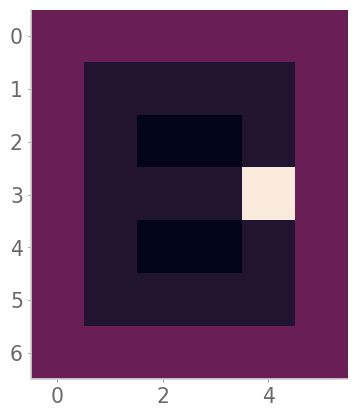

=====-===========


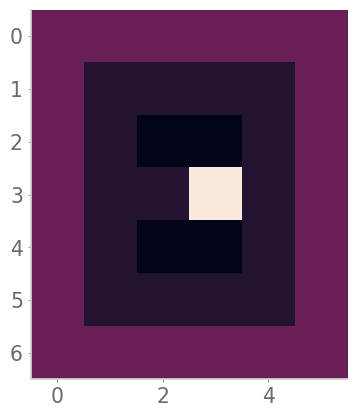

=====-===========


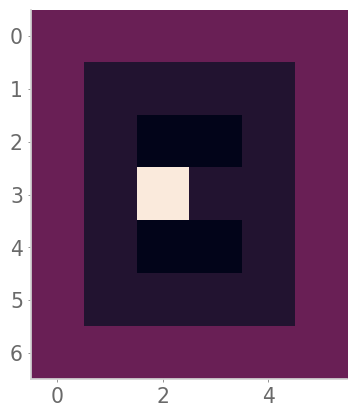

=====-===========


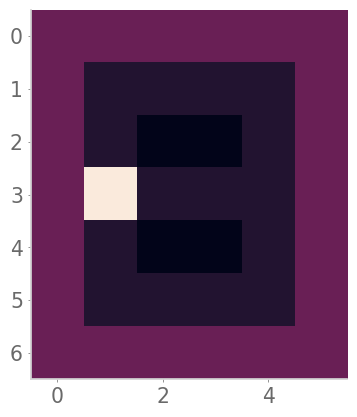

=====-===========


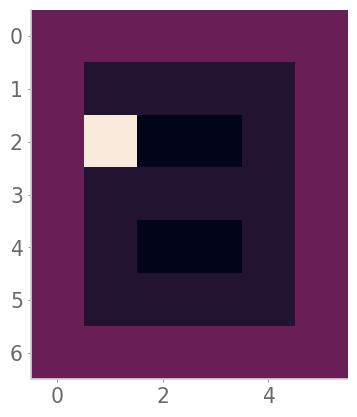

=====-===========


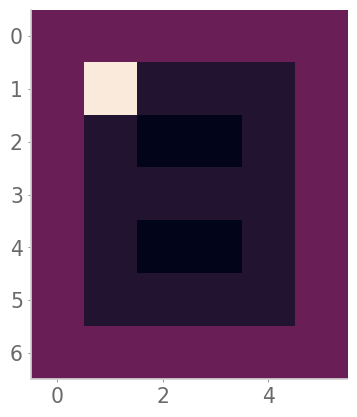

=====-===========


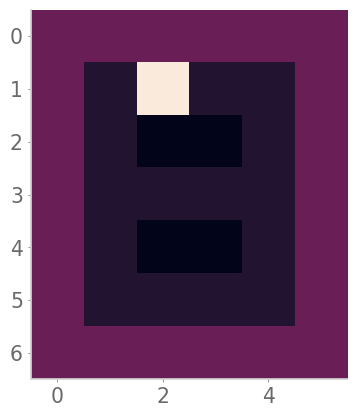

=====-===========


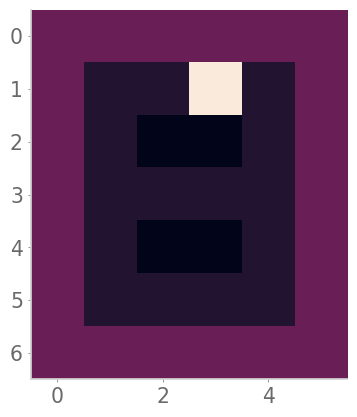

=====-===========


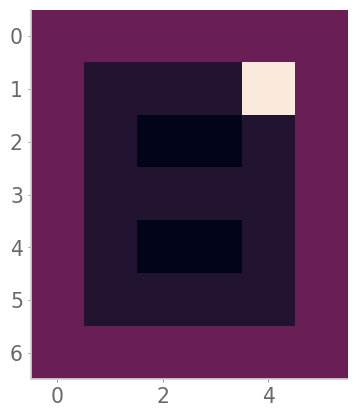

=====-===========


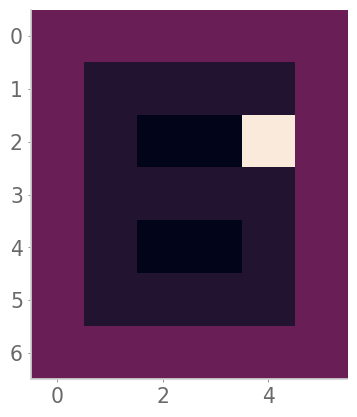

=====-===========


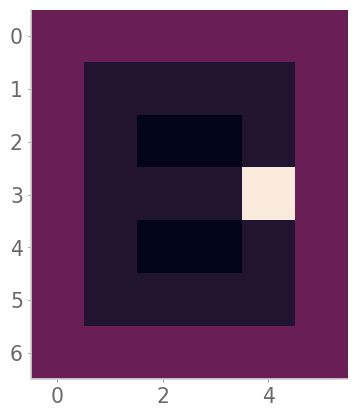

=====-===========


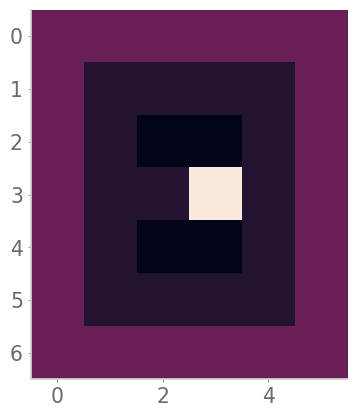

=====-===========


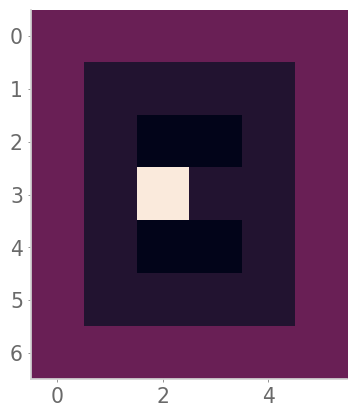

=====-===========


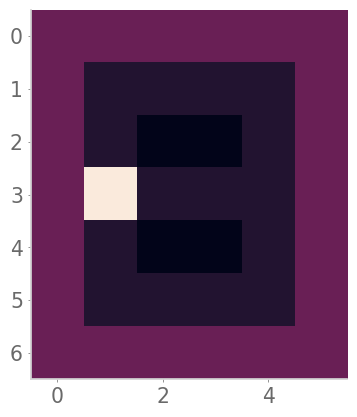

=====-===========


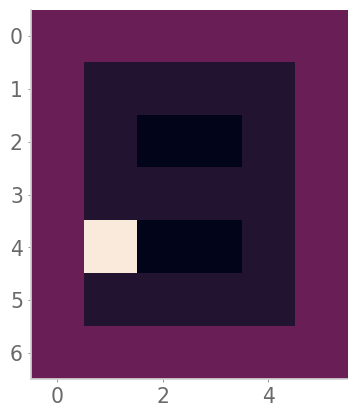

=====-===========


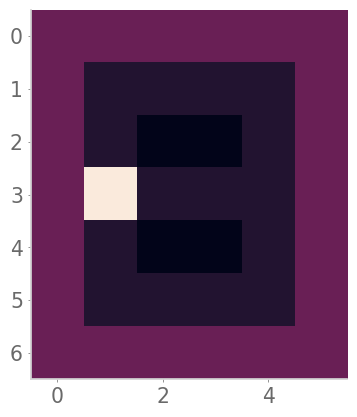

=====-===========


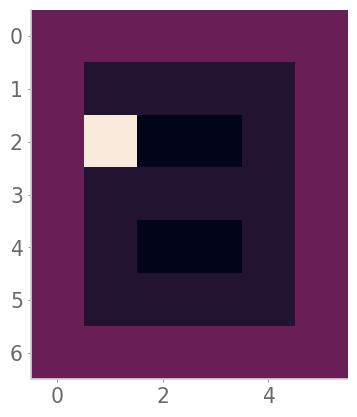

=====-===========


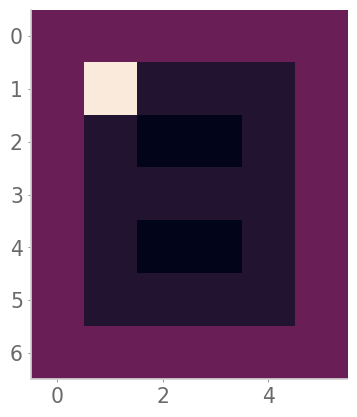

=====-===========


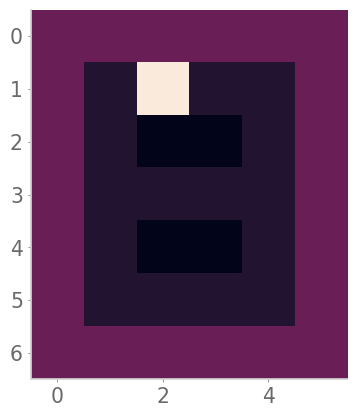

=====-===========


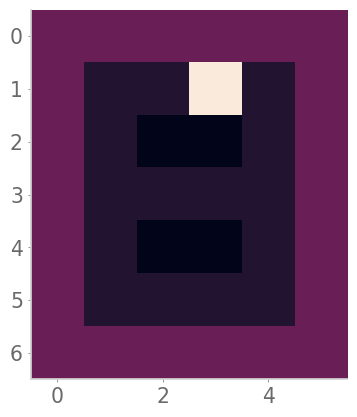

=====-===========


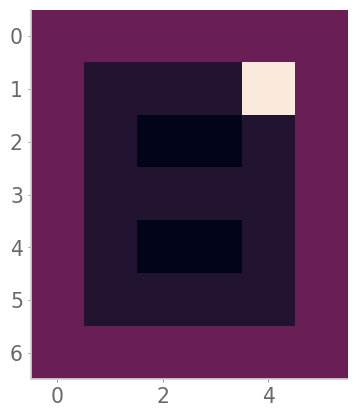

=====-===========


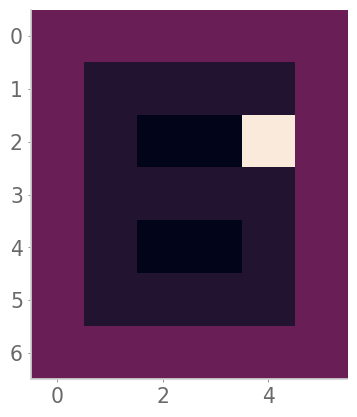

=====-===========


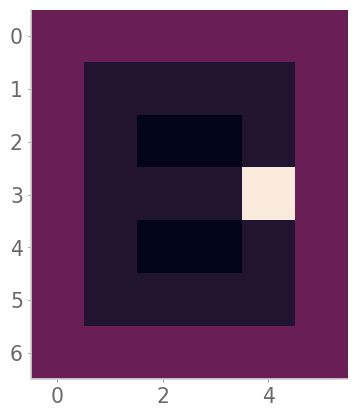

=====-===========


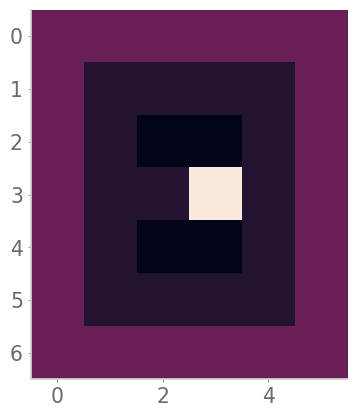

=====-===========


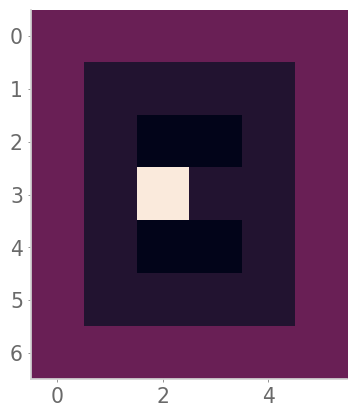

=====-===========


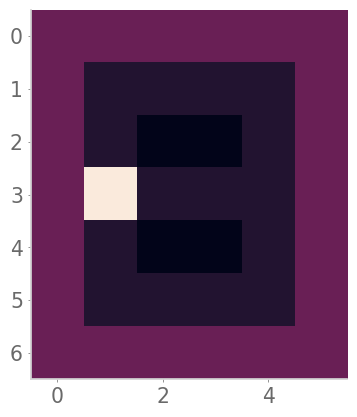

=====-===========


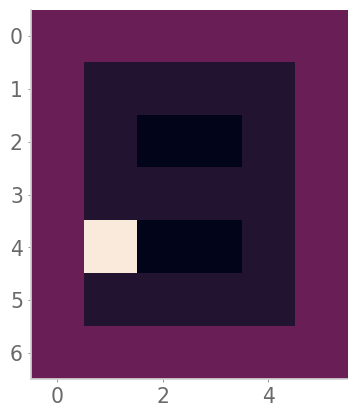

=====-===========


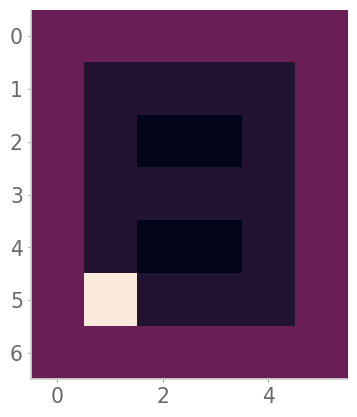

=====-===========


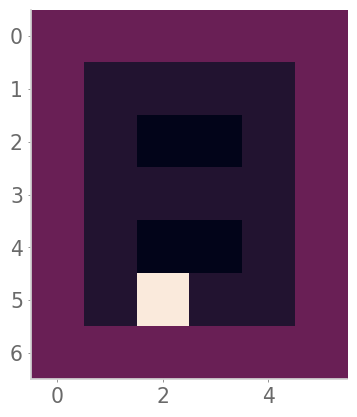

=====-===========


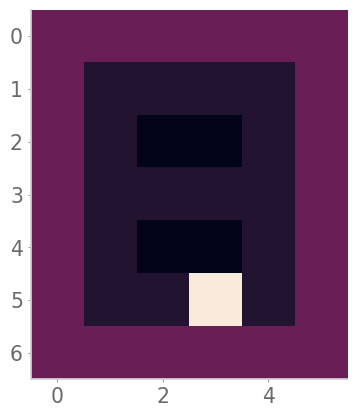

=====-===========


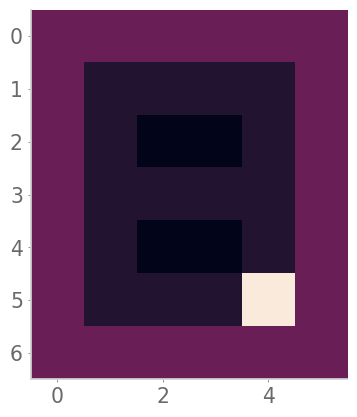

=====-===========


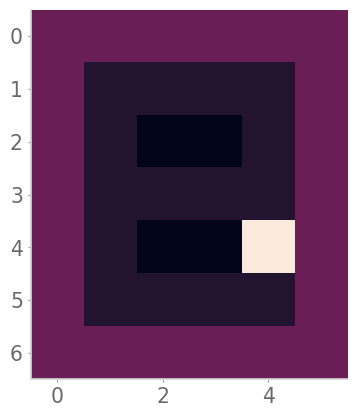

=====-===========


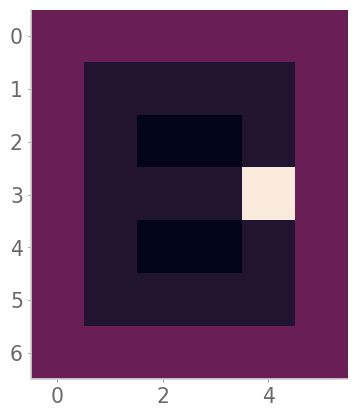

=====-===========


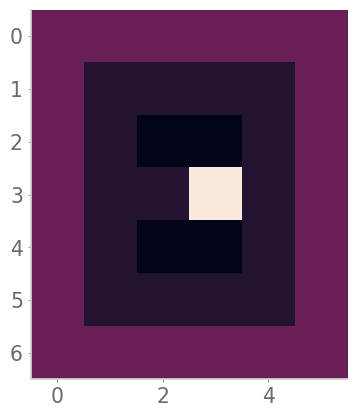

=====-===========


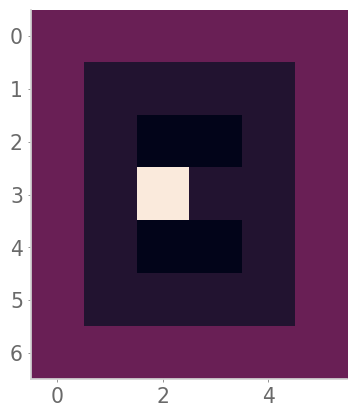

=====-===========


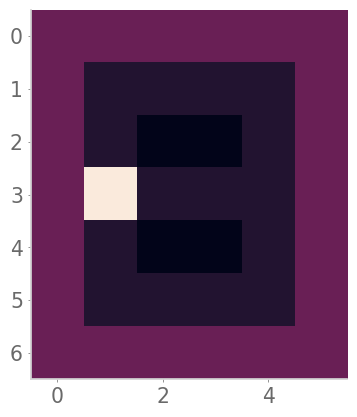

=====-===========


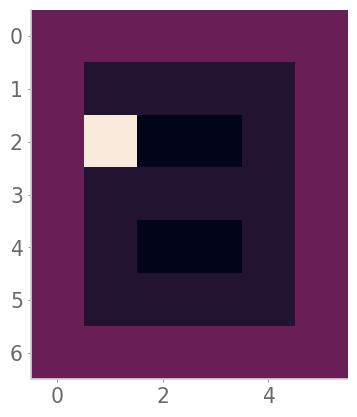

=====-===========


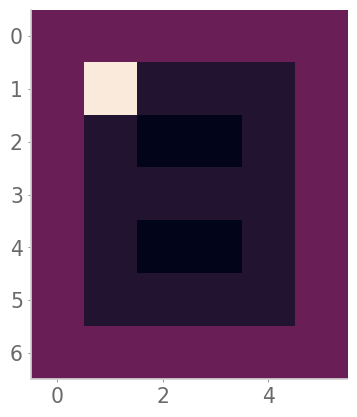

=====-===========


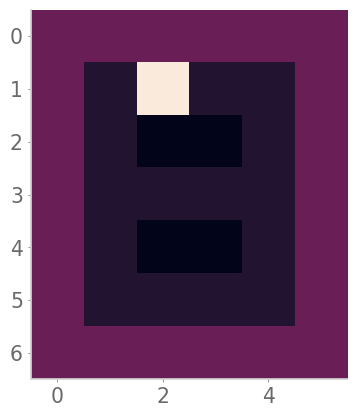

=====-===========


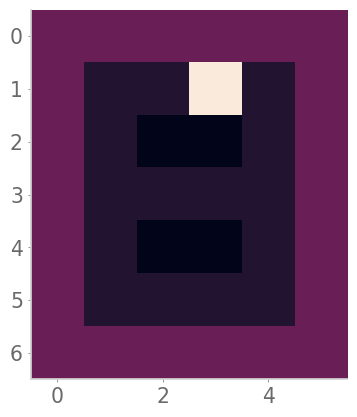

=====-===========


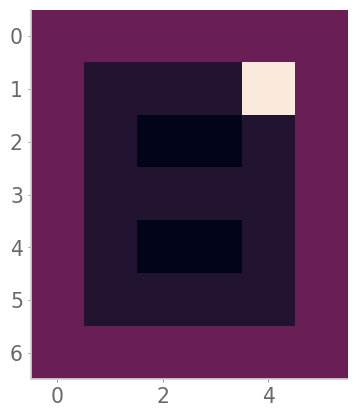

=====-===========


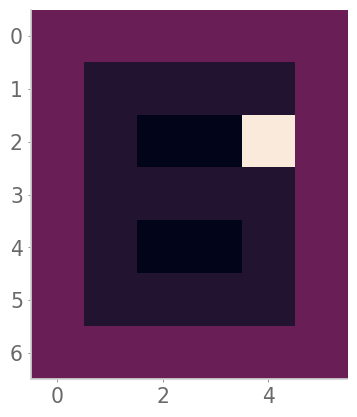

=====-===========


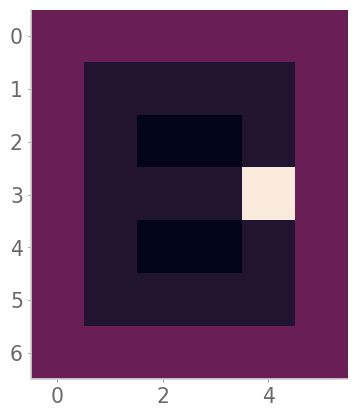

=====-===========


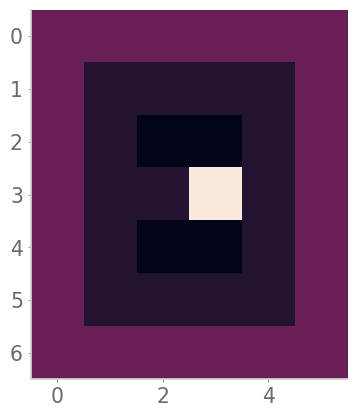

=====-===========


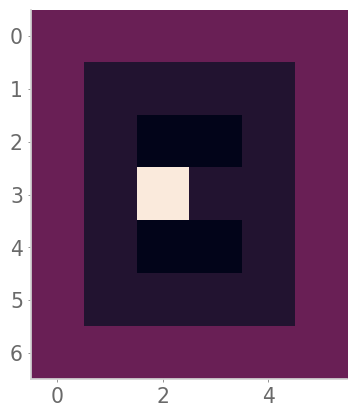

=====-===========


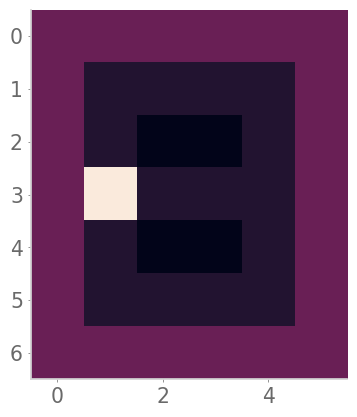

=====-===========


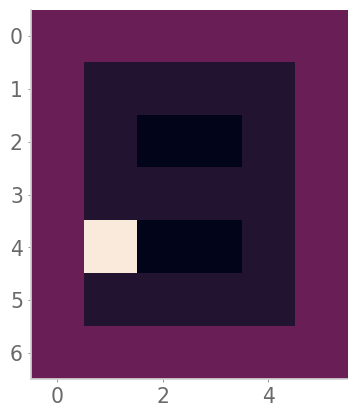

=====-===========


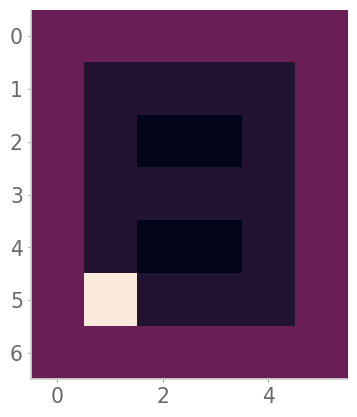

=====-===========


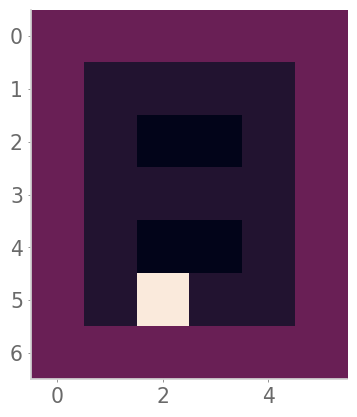

=====-===========


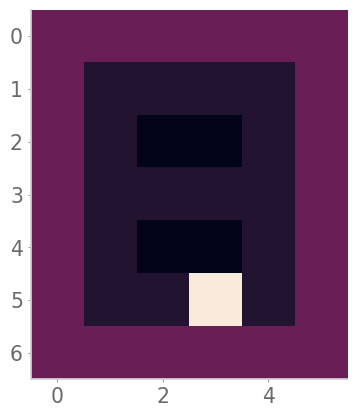

=====-===========


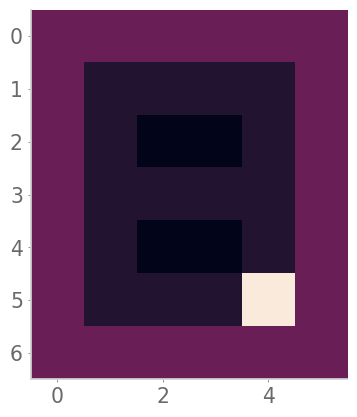

=====-===========


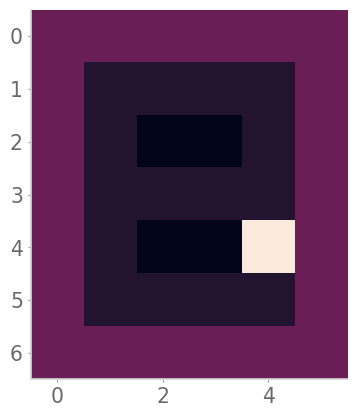

=====-===========


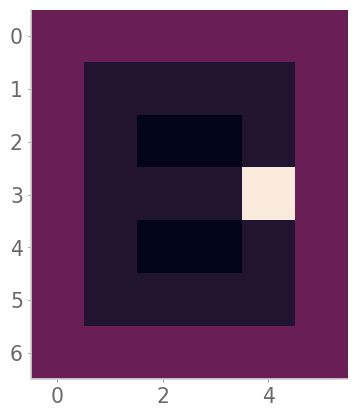

=====-===========


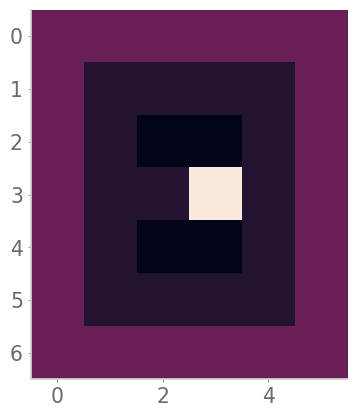

=====-===========


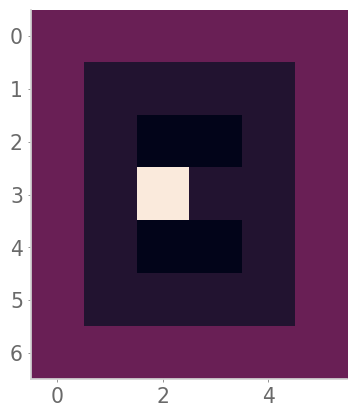

=====-===========


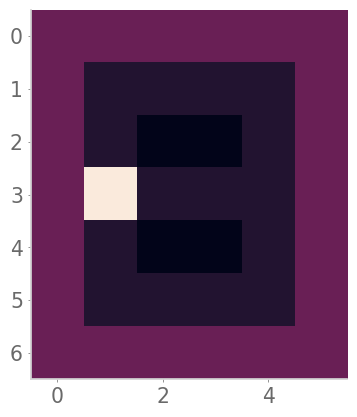

=====-===========


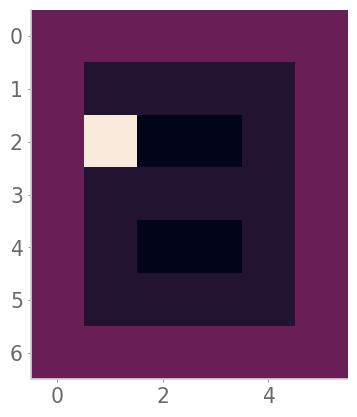

=====-===========


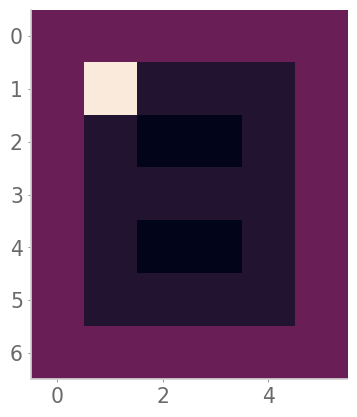

=====-===========


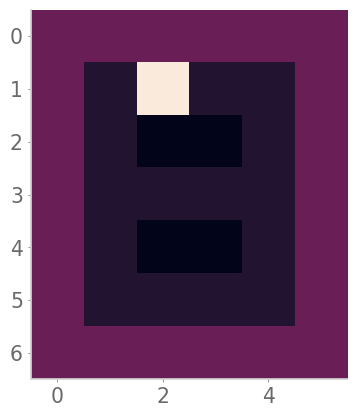

=====-===========


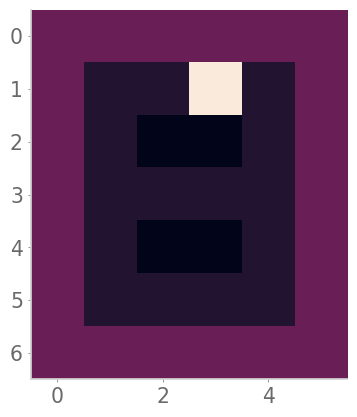

=====-===========


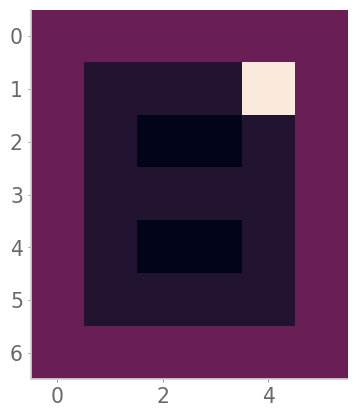

=====-===========


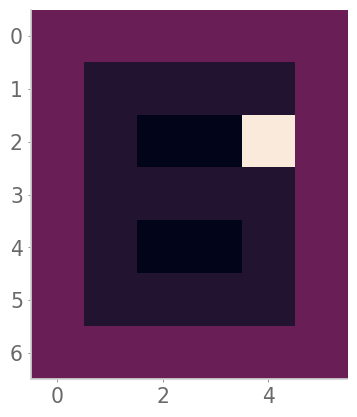

=====-===========


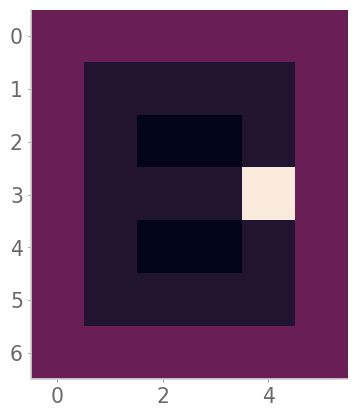

=====-===========


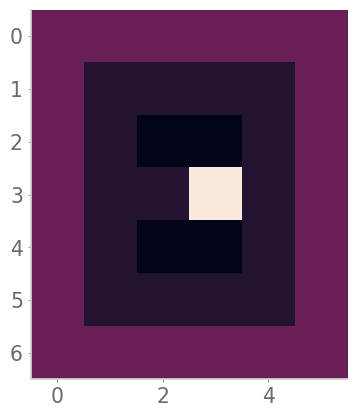

=====-===========


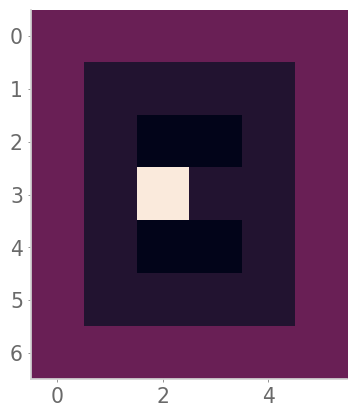

=====-===========


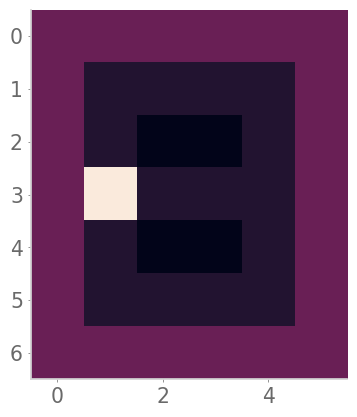

=====-===========


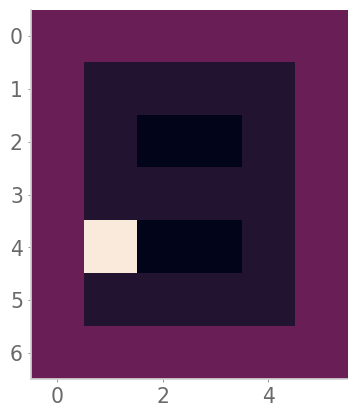

=====-===========


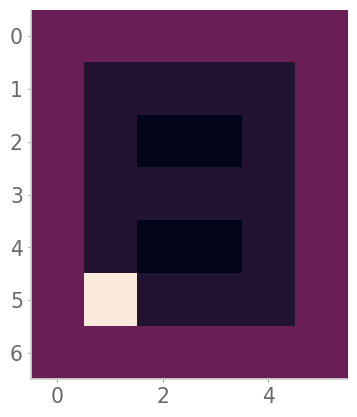

=====-===========


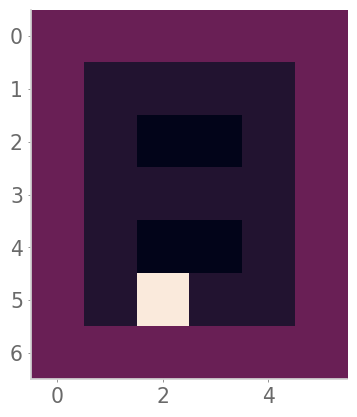

=====-===========


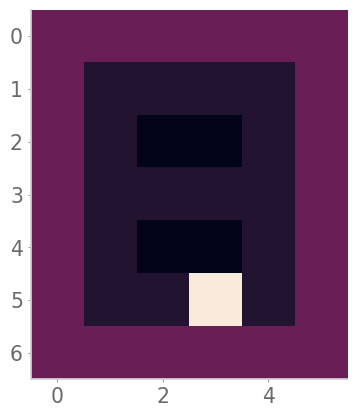

=====-===========


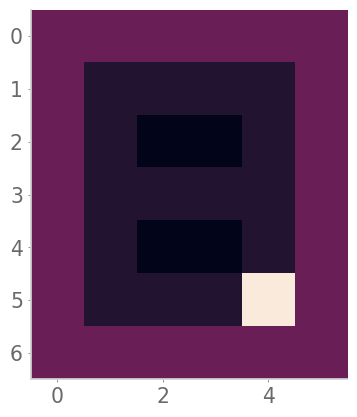

=====-===========


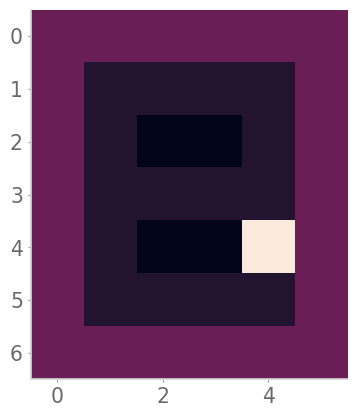

=====-===========


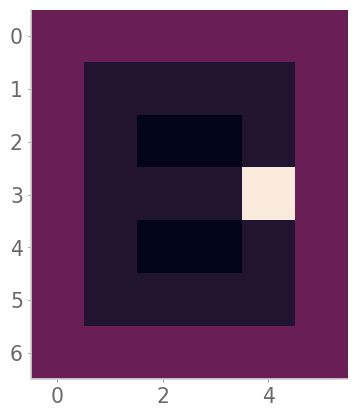

=====-===========


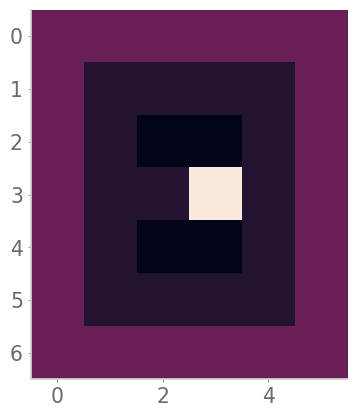

=====-===========


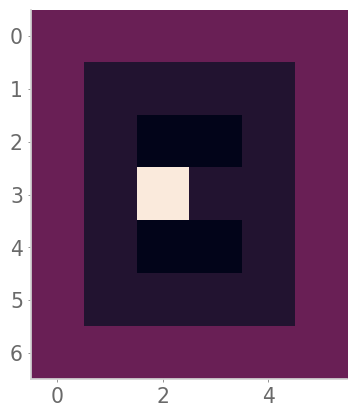

=====-===========


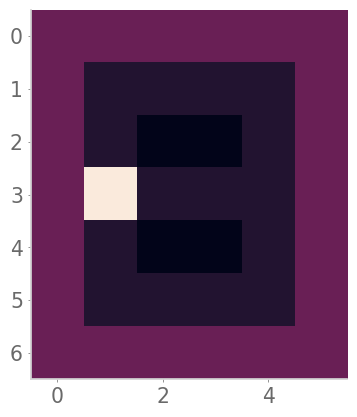

=====-===========


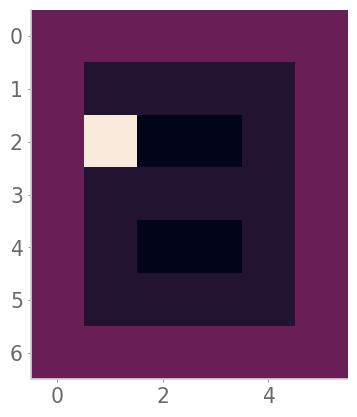

=====-===========


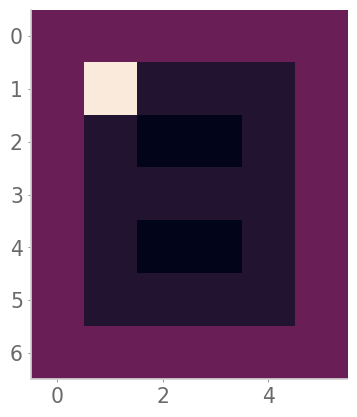

=====-===========


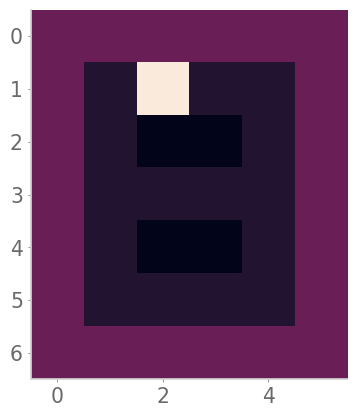

=====-===========


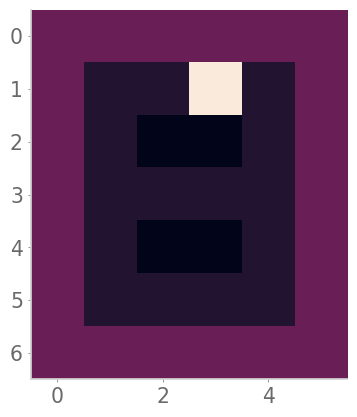

=====-===========


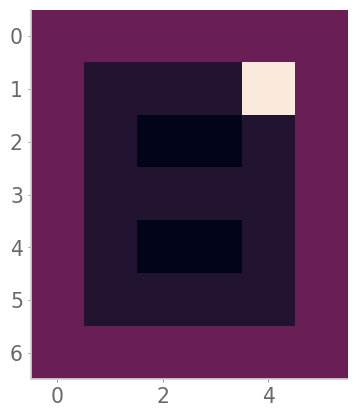

=====-===========


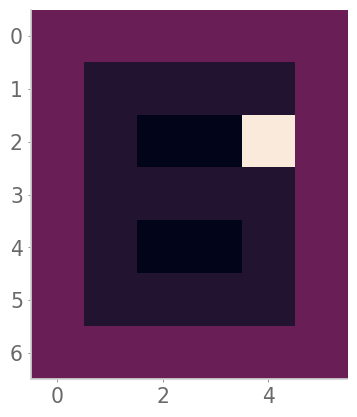

=====-===========


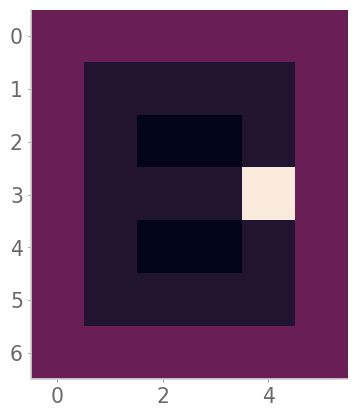

=====-===========


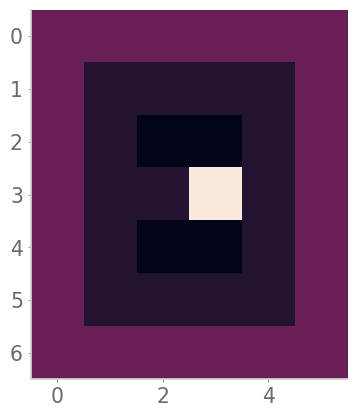

=====-===========


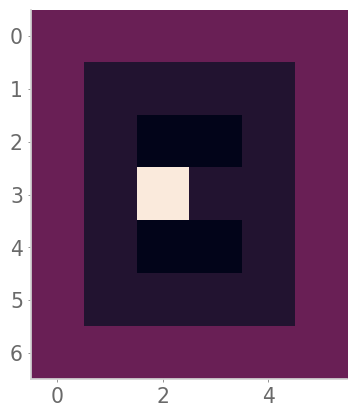

=====-===========


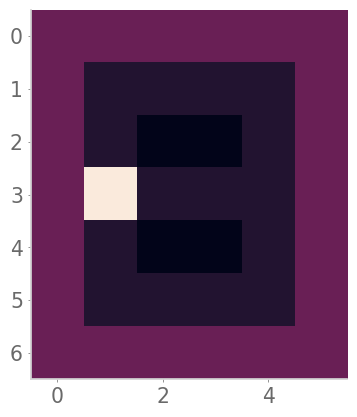

=====-===========


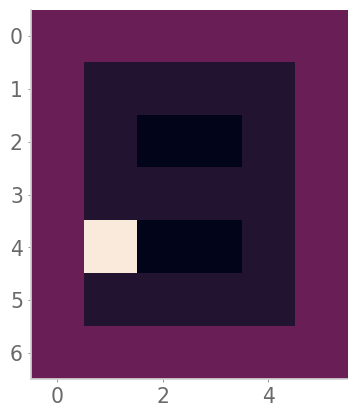

=====-===========


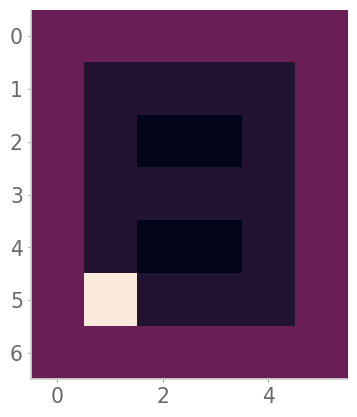

=====-===========


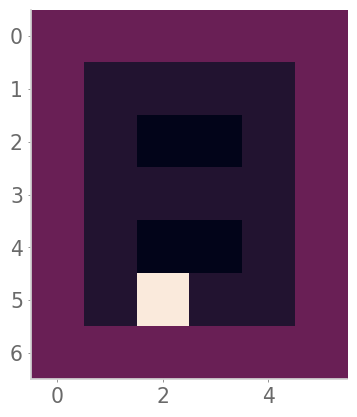

=====-===========


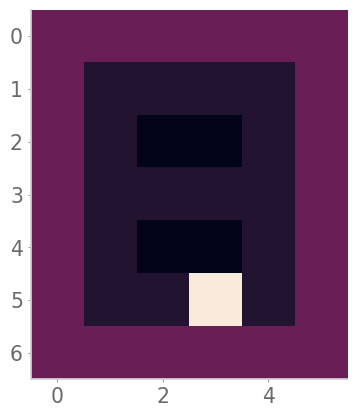

=====-===========


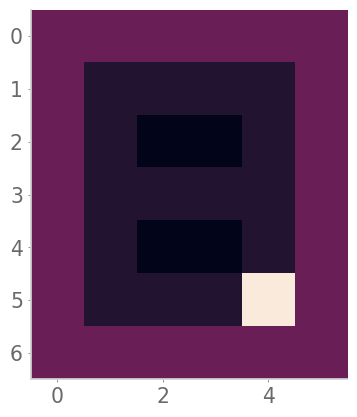

=====-===========


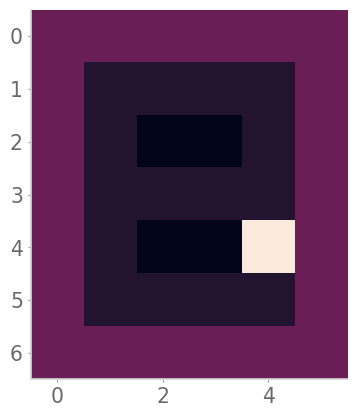

=====-===========


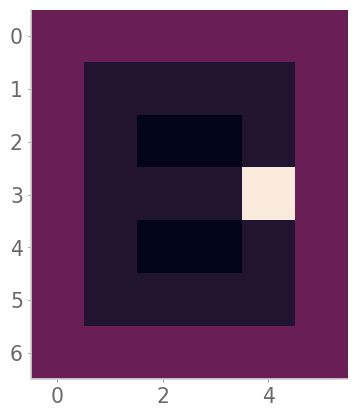

=====-===========


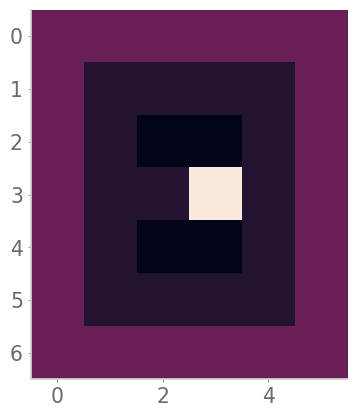

=====-===========


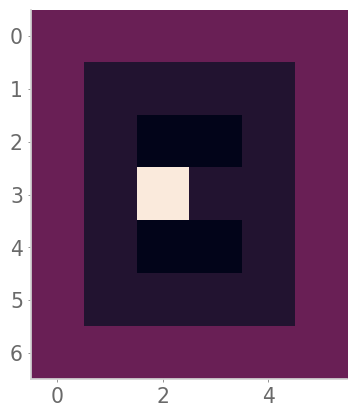

=====-===========


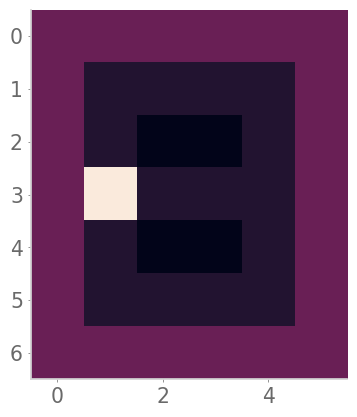

=====-===========


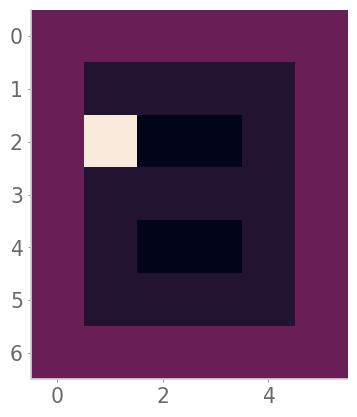

=====-===========


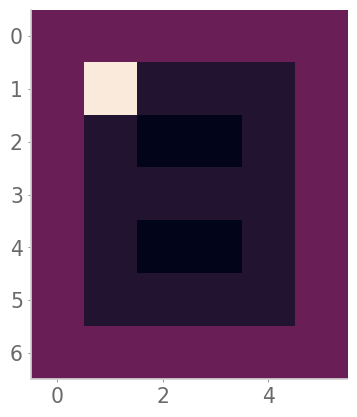

=====-===========


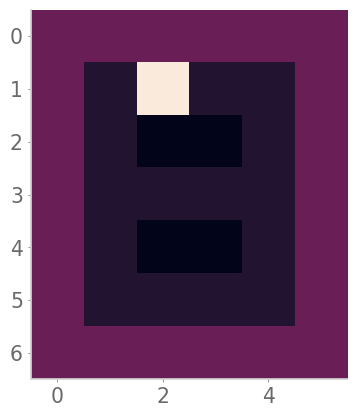

=====-===========


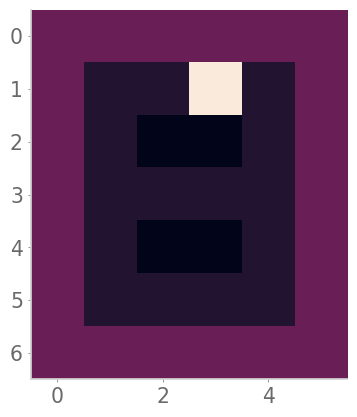

=====-===========


In [65]:
%matplotlib inline

for i in range(100):
    obs = env.observe()
    plt.figure()
    plt.imshow(np.flip(obs[0].squeeze()))
    plt.show()
    for i in range(len(obs)):
        agent._state[i] = obs[i]    

        state = torch.as_tensor(agent._state, device='cuda').float()
        zs = torch.as_tensor(agent._latent, device='cuda').float()
        latent = agent._learning_algo.crar.encoder(state, zs=zs)
        latent = latent.detach().cpu().numpy()
        agent._latent[0, 0:-1] = agent._latent[0, 1:]
        agent._latent[0, -1] = latent

    V, action, reward = agent._step()
    print('=====-===========')
    agent._Vs_on_last_episode.append(V)
    is_terminal = env.inTerminalState()
    if is_terminal: break